<h1> How to do NLP-like research in physics


This notebook provides a step-by-step demonstration/tutorial based on the Lagrangian paper.

# Acknowledge SUPR

The computations and data handling were enabled by resources provided by the National Academic Infrastructure for Supercomputing in Sweden (NAISS) from projects ????, partially funded by the Swedish Research Council through grant agreement no. 2022-06725

# Libraries

# Models
- Overview of HuggingFace library.
- How to find off-the-shelf transformer models (e.g., BART-L).
- Example usage of a HuggingFace model.

## HuggingFace Library

In [ ]:
# Import HuggingFace libraries
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

# Load a pre-trained model and tokenizer (e.g., BART-small)
# Note: You can change the model name to any other Seq2Seq model available on HuggingFace
# Model name can be changed to any other Seq2Seq model available on HuggingFace
# For example: 'facebook/bart-base', 't5-small', etc.

# 'facebook/bart-base' : BART model with 140M parameters
# 'facebook/bart-large' : BART model with 406M parameters
# 't5-small' : T5 model with 60M parameters

model_name = 'facebook/bart-base'
model = AutoModelForSeq2SeqLM.from_pretrained(model_name)
tokenizer = AutoTokenizer.from_pretrained(model_name)

# Example usage
text = "This is a sample input."
inputs = tokenizer(text, return_tensors="pt")
outputs = model.generate(**inputs)
print(tokenizer.decode(outputs[0], skip_special_tokens=True))

config.json: 0.00B [00:00, ?B/s]

model.safetensors:   0%|          | 0.00/558M [00:00<?, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

/home/ys/.local/lib/python3.8/site-packages/transformers/generation/utils.py:1133: UserWarning: Using the model-agnostic default `max_length` (=20) to control the generation length. We recommend setting `max_new_tokens` to control the maximum length of the generation.
  warnings.warn(


This is a sample input.


# Dataset
- Discussion on data generation considerations:
  - Data distribution.
  - Tokenization choices.
- Example of tokenizing a dataset.

## Data Distribution


Show plots from paper:
- one from random ->  more equal better at long expression
- one from smart  ->  more biased (cover edge terms) better at special cases

In [78]:
import pandas as pd
sampled_df = pd.read_csv("huggingface_dataset_sampled.csv")


In [79]:
sampled_df["nfields"] = sampled_df["fields"].apply(lambda x: x.count("FIELD"))
sampled_df["nfermions"] = sampled_df["fields"].apply(lambda x: x.count("SPIN 1"))
sampled_df["nscalars"] = sampled_df["fields"].apply(lambda x: x.count("SPIN 0"))

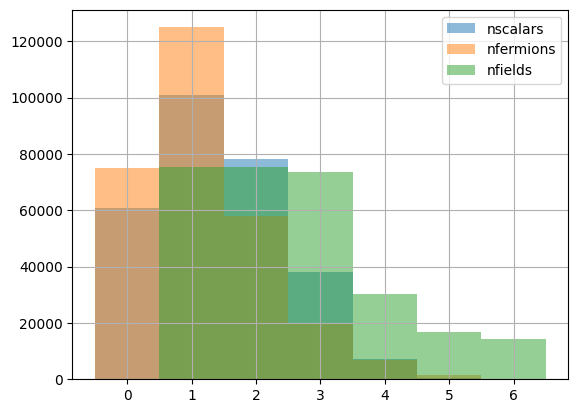

In [80]:
import matplotlib.pyplot as plt
sampled_df["nscalars"].hist(  range=(0-0.5,7-0.5),bins=7,alpha=0.5,label="nscalars") 
sampled_df["nfermions"].hist( range=(0-0.5,7-0.5),bins=7,alpha=0.5,label="nfermions") 
sampled_df["nfields"].hist(   range=(0-0.5,7-0.5),bins=7,alpha=0.5,label="nfields") 
plt.legend()

## Tokenization choices
Considerations: 
- What information is required for your model to learn?
- Do you care about expressivity? 

Practical 
- How much information?
- Vocabulary Size?

### Choices of Tokenization

In Language:
Example Phrase : AI For Physics
- Word-Level : AI, For, Physics
- Character-Level : A, I,  , F, o, r,  , P, h, y, s, i, c, s

In Math:
Example Expression : 100 + 420 = 520
- "Term"-level : 100, +, 420, =, 520
- "Digit"-Level : 1, 0, 0,  +,  4, 2, 0, =,  5, 2, 0

In Lagrangians:
Example Field : Higgs Particle
- Symbol Level : H
- Quantum-Numbers-Level: FIELD, SPIN, 0, SU2, 2, U1, 1



Remark: 
1. Detailed tokenization : 
- less vocabulary
- more expressive
- more token per sequence
- heavy on attention mechanism
2. Coarse tokenization : 
- more vocabulary
- less expressive
- less token per sequence
- easier on attention mechanism

### Example : Math 

In [64]:
import random 
from tokenizers import Tokenizer
from tokenizers.models import WordLevel
from tokenizers.trainers import WordLevelTrainer
from tokenizers.pre_tokenizers import Whitespace

# Character-level 
# 1. Generate arithmetic corpus
char_level_corpus = [" ".join(list(f"{a}+{b}={str(a + b)}")) for a in range(100) for b in range(100)]
vocab = {"1" : 1, "2" : 2, "3" : 3, "4" : 4, "5" : 5, "6" : 6, "7" : 7, "8" : 8, "9" : 9,
         "0" : 0, "+" : 10, "=" : 11,"[UNK]" : 12, "[PAD]" : 13, "[BOS]" : 14, "[EOS]" : 15}
# 2. Initialize tokenizer components
char_level_tokenizer = Tokenizer(WordLevel(vocab=vocab, unk_token="[UNK]"))
char_level_tokenizer.pre_tokenizer = Whitespace()


# Word-level 
word_level_corpus = [f"{a} + {b} = {str(a + b)}" for a in range(100) for b in range(100)]
word_level_tokenizer = Tokenizer(WordLevel(unk_token="[UNK]"))
word_level_tokenizer.pre_tokenizer = Whitespace()
special_tokens = ["[PAD]", "[UNK]", "[BOS]", "[EOS]"]
trainer = WordLevelTrainer(special_tokens=special_tokens)
word_level_tokenizer.train_from_iterator(word_level_corpus, trainer)



lets see it in action

In [75]:
char_level_example = random.choice(char_level_corpus)
print("char_level_example : ",char_level_example)
print("char_level_tokens  : ",char_level_tokenizer.encode(char_level_example).tokens,end="\n\n")

word_level_example = random.choice(word_level_corpus)
print("word_level_example : ",word_level_example)
print("word_level_tokens  : ",word_level_tokenizer.encode(word_level_example).tokens,end="\n\n")

char_level_example :  7 3 + 1 7 = 9 0
char_level_tokens  :  ['7', '3', '+', '1', '7', '=', '9', '0']

word_level_example :  53 + 44 = 97
word_level_tokens  :  ['53', '+', '44', '=', '97']



Lets check vocab size

In [76]:
print("char_level_vocab_size: ",char_level_tokenizer.get_vocab_size())
print("word_level_vocab_size: ",word_level_tokenizer.get_vocab_size())

char_level_vocab_size:  16
word_level_vocab_size:  205


Try encoding 10000

In [77]:
OOD_char_level_example =   "1 0 0 0 0"
print("char_level_tokens  : ",char_level_tokenizer.encode(OOD_char_level_example).tokens,end="\n\n")

OOD_word_level_example =   "10000"
print("word_level_tokens  : ",word_level_tokenizer.encode(OOD_word_level_example).tokens,end="\n\n")

char_level_tokens  :  ['1', '0', '0', '0', '0']

word_level_tokens  :  ['[UNK]']



### Example : Fields 

In [104]:
example = sampled_df.sample(1)["fields"].values[0]
print("Input    = ",example)
encoded = hf_tokenizer.encode(example)
print("token_id = ", encoded)
decoded = hf_tokenizer.decode(encoded)
print("decoded  = ", decoded)


Input    =  FIELD SPIN 0 SU2 2 U1 - 1 FIELD SPIN 1/2 SU3 - 3 U1 - 4 / 7 HEL -1/2
token_id =  [22, 36, 9, 37, 6, 39, 7, 5, 22, 36, 5, 4, 6, 38, 7, 10, 39, 7, 11, 4, 14, 23, 7, 5, 4, 6]
decoded  =  FIELD SPIN 0 SU2 2 U1 - 1 FIELD SPIN 1 / 2 SU3 - 3 U1 - 4 / 7 HEL - 1 / 2


# Training
- Mention available resources: SUPR/NAISS -> Alvis.
- Example of training a model.

### NAISS : https://www.naiss.se/
### SUPR : https://supr.naiss.se/
### Alvis : https://www.c3se.chalmers.se/about/Alvis/
### OnDemand Portal : https://alvis.c3se.chalmers.se/pun/sys/dashboard/

## CPU or GPU

In [2]:
# Choose GPU if available
import torch

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")


# Evaluation
- Generating output from the model.
- Discussion on evaluation choices:
  - Existing or novel metrics.
  - Embedding analysis.
  - Out-of-distribution tests.

## Existing Metric  : Does it work? 

mainly to see if things work as expected
Loss : Deviation from actual term 
Accuracy : How much is perfect? 
New metric, Score : (Order does not always matter, XEN)

In [ ]:
from transformers import BartForConditionalGeneration, PreTrainedTokenizerFast

model_name = "JoseEliel/BART-Lagrangian"
model = BartForConditionalGeneration.from_pretrained(model_name)
hf_tokenizer = PreTrainedTokenizerFast.from_pretrained(model_name)


In [184]:
sampled_df.drop_duplicates(subset=["fields"], inplace=True)

In [185]:
sampled_df

,fields,Lagrangian,train/eval,nfields,nfermions,nscalars,output_length
0,FIELD SPIN 1/2 SU3 - 3 SU2 2 U1 - 4 HEL 1/2 FI...,+ FIELD SPIN 1 / 2 SU3 - 3 SU2 2 HEL - 1 / 2 D...,eval,3,2,1,411
1,FIELD SPIN 1/2 HEL 1/2 FIELD SPIN 1/2 SU3 - 3 ...,+ i FIELD SPIN 1 / 2 HEL 1 / 2 ID9 SIGMA_BAR I...,eval,2,2,0,225
2,FIELD SPIN 0 SU2 3 U1 - 4 / 9 FIELD SPIN 1/2 S...,+ FIELD SPIN 0 SU2 3 U1 - 4 / 9 ID1 FIELD SPIN...,eval,4,2,2,1161
3,FIELD SPIN 1/2 SU3 - 3 U1 3 / 8 HEL -1/2 FIELD...,+ FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 8 / 9 ID3 FI...,eval,5,4,1,675
4,FIELD SPIN 0 SU3 3 SU2 3,+ FIELD SPIN 0 SU3 3 SU2 3 ID4 FIELD SPIN 0 SU...,eval,1,0,1,547
...,...,...,...,...,...,...,...
286076,FIELD SPIN 0 SU3 3 SU2 3 U1 9 / 2 FIELD SPIN 1...,+ FIELD SPIN 1 / 2 SU2 2 U1 1 / 5 HEL - 1 / 2 ...,train,4,1,3,1551
286077,FIELD SPIN 0 FIELD SPIN 0 SU3 3 SU2 3 U1 7 / 6...,+ FIELD SPIN 0 ID1 FIELD SPIN 0 SU3 3 SU2 3 U1...,train,3,1,2,815
286078,FIELD SPIN 0 SU3 - 3 U1 3 FIELD SPIN 1/2 SU3 3...,+ FIELD SPIN 0 SU3 - 3 U1 3 ID4 FIELD SPIN 0 S...,train,3,1,2,953
286079,FIELD SPIN 1/2 U1 - 4 / 5 HEL -1/2 FIELD SPIN ...,+ FIELD SPIN 0 SU3 - 3 SU2 2 U1 - 1 / 7 ID6 FI...,train,2,1,1,481


In [186]:
sampled_df["output_length"] = sampled_df["Lagrangian"].apply(lambda x: len(x.split()))
minlength = sampled_df["output_length"].min()
sampled_df[sampled_df["output_length"] == minlength]

,fields,Lagrangian,train/eval,nfields,nfermions,nscalars,output_length
377,FIELD SPIN 0,+ FIELD SPIN 0 ID2 FIELD SPIN 0 ID3 FIELD SPIN...,eval,1,0,1,59


In [ ]:
example_scenario = sampled_df.sample(1)
example = example_scenario["fields"].values[0]
example = "[SOS] " + example + " [EOS]"
print("Input    = ",example)
encoded = hf_tokenizer.encode(example)
print("token_id = ", encoded)
decoded = hf_tokenizer.decode(encoded)
print("decoded  = ", decoded)


Input    =  [SOS] FIELD SPIN 0 SU2 3 FIELD SPIN 0 SU3 - 3 U1 - 1 / 3 FIELD SPIN 1/2 SU3 3 SU2 3 U1 - 8 / 5 HEL 1/2 FIELD SPIN 1/2 SU3 3 U1 - 1 / 4 HEL 1/2 FIELD SPIN 0 SU2 2 U1 5 FIELD SPIN 0 SU3 - 3 SU2 3 U1 1 / 7 [EOS]
token_id =  [0, 22, 36, 9, 37, 10, 22, 36, 9, 38, 7, 10, 39, 7, 5, 4, 10, 22, 36, 5, 4, 6, 38, 10, 37, 10, 39, 7, 15, 4, 12, 23, 5, 4, 6, 22, 36, 5, 4, 6, 38, 10, 39, 7, 5, 4, 11, 23, 5, 4, 6, 22, 36, 9, 37, 6, 39, 12, 22, 36, 9, 38, 7, 10, 37, 10, 39, 5, 4, 14, 1]
decoded  =  [SOS] FIELD SPIN 0 SU2 3 FIELD SPIN 0 SU3 - 3 U1 - 1 / 3 FIELD SPIN 1 / 2 SU3 3 SU2 3 U1 - 8 / 5 HEL 1 / 2 FIELD SPIN 1 / 2 SU3 3 U1 - 1 / 4 HEL 1 / 2 FIELD SPIN 0 SU2 2 U1 5 FIELD SPIN 0 SU3 - 3 SU2 3 U1 1 / 7 [EOS]


In [205]:
example_scenario = sampled_df[sampled_df["output_length"] == minlength]
example = example_scenario["fields"].values[0]
example = "[SOS] " + example + " [EOS]"
print("Input    = ",example)


encoded = hf_tokenizer.encode(example, return_tensors='pt', truncation=True,padding=True)
print("Encoded  = ",encoded)

inputs = hf_tokenizer(example, return_tensors="pt")
with hf_tokenizer.as_target_tokenizer():
    targets = hf_tokenizer(example_scenario["Lagrangian"].iloc[0], return_tensors="pt")

labels = targets["input_ids"]

#true_ids = hf_tokenizer.encode(example_scenario["Lagrangian"].iloc[0])
print("inputs:\n",inputs)
print("targets:\n",labels)


with torch.no_grad():
    outputs = model(input_ids=inputs["input_ids"], labels=labels)
    logits = outputs.logits  # shape: [batch_size, seq_len, vocab_size]


Input    =  [SOS] FIELD SPIN 0 [EOS]
Encoded  =  tensor([[ 0, 22, 36,  9,  1]])
inputs:
 {'input_ids': tensor([[ 0, 22, 36,  9,  1]]), 'token_type_ids': tensor([[0, 0, 0, 0, 0]]), 'attention_mask': tensor([[1, 1, 1, 1, 1]])}
targets:
 tensor([[ 8, 22, 36,  9, 26, 22, 36,  9, 27, 22, 36,  9, 32,  8, 22, 36,  9, 25,
         22, 36,  9, 29, 22, 36,  9, 31, 22, 36,  9, 24,  8, 21, 29, 22, 36,  9,
         20, 32, 21, 27, 22, 36,  9, 31, 19, 34, 29, 27,  8, 22, 36,  9, 20, 33,
         22, 36,  9, 26, 19]])


In [206]:
# Shift logits and labels for computing loss
logits = logits[:, :-1, :].contiguous()
target_ids = labels[:, 1:].contiguous()

# Flatten for loss computation
loss_fct = torch.nn.CrossEntropyLoss(reduction='none')  # No reduction to get per-token loss
loss = loss_fct(logits.view(-1, logits.size(-1)), target_ids.view(-1))

# Reshape to [batch_size, seq_len]
token_losses = loss.view(target_ids.size())

print("Per-token cross-entropy losses:", token_losses)


Per-token cross-entropy losses: tensor([[19.2422, 10.0482, 22.0277, 20.2395, 14.0827, 15.6187, 22.3550, 22.3186,
         13.3089, 12.9028, 22.5419, 20.7454, 11.9949, 10.5809, 14.4918, 23.0722,
         20.3395, 14.2646, 19.0891, 23.6852, 20.2923, 14.0048, 20.1847, 23.1815,
         21.7371, 14.0884, 18.0260, 22.7415, 22.5128, 12.7312, 17.2330, 21.4783,
         13.8880, 19.9695, 22.9877, 17.8990, 18.0639, 14.0775, 22.6056, 13.2294,
         16.9861, 22.6753, 21.4662, 14.4006, 21.6495, 26.4088, 18.5562, 17.1748,
         15.8664, 13.4955, 23.1618, 19.2413, 17.7145, 13.8378, 17.7131, 23.4729,
         20.2655, 13.3533]])


In [170]:
predicted_lagrangian = hf_tokenizer.batch_decode(outputs, skip_special_tokens=True)[0]
print(predicted_lagrangian)


+ FIELD SPIN 0 SU2 3 U1 4 ID7 FIELD SPIN 0 SU2 3 U1 - 4 DAGGER ID0 FIELD SPIN 0 U1 9 / 8 ID8 FIELD SPIN 0 U1 - 9 / 8 DAGGER ID2 CONTRACTIONS SU2 ID7 ID0 SU2 ID7 ID0 + FIELD SPIN 0 SU2 3 U1 4 ID6 FIELD SPIN 0 SU2 3 U1 - 4 DAGGER ID7 FIELD SPIN 0 SU2 3 U1 5 ID4 FIELD SPIN 0 SU2 3 U1 - 5 DAGGER ID1 CONTRACTIONS SU2 ID6 ID4 SU2 ID6 ID4 SU2 ID7 ID1 SU2 ID7 ID1 + FIELD SPIN 0 SU2 3 U1 4 ID7 FIELD SPIN 0 SU2 3 U1 - 4 DAGGER ID0 FIELD SPIN 0 SU2 3 U1 5 ID9 FIELD SPIN 0 SU2 3 U1 - 5 DAGGER ID8 CONTRACTIONS SU2 ID7 ID0 SU2 ID7 ID9 SU2 ID0 ID8 SU2 ID9 ID8 + FIELD SPIN 0 SU2 3 U1 4 ID7 FIELD SPIN 0 SU2 3 U1 - 4 DAGGER ID0 FIELD SPIN 0 SU2 3 U1 5 ID9 FIELD SPIN 0 SU2 3 U1 - 5 DAGGER ID8 CONTRACTIONS SU2 ID7 ID0 SU2 ID7 ID0 SU2 ID9 ID8 SU2 ID9 ID8 + FIELD SPIN 0 SU2 3 U1 4 ID7 FIELD SPIN 0 SU2 3 U1 - 4 DAGGER ID0 FIELD SPIN 0 SU3 3 U1 4 / 9 ID2 FIELD SPIN 0 SU3 - 3 U1 - 4 / 9 DAGGER ID6 CONTRACTIONS SU3 ID2 ID6 ID6 SU2 ID7 ID0 SU2 ID7 ID0 + FIELD SPIN 0 SU2 3 U1 4 ID6 FIELD SPIN 0 SU2 3 U1 4 ID0 FIE

In [164]:
true_lagrangian = example_scenario["Lagrangian"].iloc[0]
print(true_lagrangian)


+ FIELD SPIN 0 SU2 3 U1 4 ID0 FIELD SPIN 0 SU2 3 U1 - 4 DAGGER ID1 FIELD SPIN 0 U1 9 / 8 ID2 FIELD SPIN 0 U1 - 9 / 8 DAGGER ID3 CONTRACTIONS SU2 ID0 ID1 SU2 ID0 ID1 + FIELD SPIN 0 SU2 3 U1 4 ID1 FIELD SPIN 0 SU2 3 U1 - 4 DAGGER ID3 FIELD SPIN 0 SU2 3 U1 5 ID4 FIELD SPIN 0 SU2 3 U1 - 5 DAGGER ID7 CONTRACTIONS SU2 ID1 ID4 SU2 ID1 ID4 SU2 ID3 ID7 SU2 ID3 ID7 + FIELD SPIN 0 SU2 3 U1 4 ID5 FIELD SPIN 0 SU2 3 U1 - 4 DAGGER ID8 FIELD SPIN 0 SU2 3 U1 5 ID3 FIELD SPIN 0 SU2 3 U1 - 5 DAGGER ID7 CONTRACTIONS SU2 ID5 ID8 SU2 ID5 ID3 SU2 ID8 ID7 SU2 ID3 ID7 + FIELD SPIN 0 SU2 3 U1 4 ID4 FIELD SPIN 0 SU2 3 U1 - 4 DAGGER ID5 FIELD SPIN 0 SU2 3 U1 5 ID6 FIELD SPIN 0 SU2 3 U1 - 5 DAGGER ID0 CONTRACTIONS SU2 ID4 ID5 SU2 ID4 ID5 SU2 ID6 ID0 SU2 ID6 ID0 + FIELD SPIN 0 SU2 3 U1 4 ID4 FIELD SPIN 0 SU2 3 U1 - 4 DAGGER ID8 FIELD SPIN 0 SU3 3 U1 4 / 9 ID3 FIELD SPIN 0 SU3 - 3 U1 - 4 / 9 DAGGER ID9 CONTRACTIONS SU3 ID3 ID9 ID9 SU2 ID4 ID8 SU2 ID4 ID8 + FIELD SPIN 0 SU2 3 U1 4 ID3 FIELD SPIN 0 SU2 3 U1 4 ID2 FIE

In [171]:
print(true_lagrangian)
print(predicted_lagrangian)


+ FIELD SPIN 0 SU2 3 U1 4 ID0 FIELD SPIN 0 SU2 3 U1 - 4 DAGGER ID1 FIELD SPIN 0 U1 9 / 8 ID2 FIELD SPIN 0 U1 - 9 / 8 DAGGER ID3 CONTRACTIONS SU2 ID0 ID1 SU2 ID0 ID1 + FIELD SPIN 0 SU2 3 U1 4 ID1 FIELD SPIN 0 SU2 3 U1 - 4 DAGGER ID3 FIELD SPIN 0 SU2 3 U1 5 ID4 FIELD SPIN 0 SU2 3 U1 - 5 DAGGER ID7 CONTRACTIONS SU2 ID1 ID4 SU2 ID1 ID4 SU2 ID3 ID7 SU2 ID3 ID7 + FIELD SPIN 0 SU2 3 U1 4 ID5 FIELD SPIN 0 SU2 3 U1 - 4 DAGGER ID8 FIELD SPIN 0 SU2 3 U1 5 ID3 FIELD SPIN 0 SU2 3 U1 - 5 DAGGER ID7 CONTRACTIONS SU2 ID5 ID8 SU2 ID5 ID3 SU2 ID8 ID7 SU2 ID3 ID7 + FIELD SPIN 0 SU2 3 U1 4 ID4 FIELD SPIN 0 SU2 3 U1 - 4 DAGGER ID5 FIELD SPIN 0 SU2 3 U1 5 ID6 FIELD SPIN 0 SU2 3 U1 - 5 DAGGER ID0 CONTRACTIONS SU2 ID4 ID5 SU2 ID4 ID5 SU2 ID6 ID0 SU2 ID6 ID0 + FIELD SPIN 0 SU2 3 U1 4 ID4 FIELD SPIN 0 SU2 3 U1 - 4 DAGGER ID8 FIELD SPIN 0 SU3 3 U1 4 / 9 ID3 FIELD SPIN 0 SU3 - 3 U1 - 4 / 9 DAGGER ID9 CONTRACTIONS SU3 ID3 ID9 ID9 SU2 ID4 ID8 SU2 ID4 ID8 + FIELD SPIN 0 SU2 3 U1 4 ID3 FIELD SPIN 0 SU2 3 U1 4 ID2 FIE

In [166]:
truth_ids = hf_tokenizer.encode(true_lagrangian)

In [ ]:

def get_lagrangian_score_ys(predicted, expected,verbose=False,force=False):
    if not force: 
        raise KeyError("Dont use this (we modified the score to have length penalty thtat takes in only extra tersm). Use get_lagrangian_score. If really want to use it, switch force=True")

    # 1. Separate terms
    # 2. Check for repeating terms, if repeat mod ID accordingly
    # 3. Get all possible combinations of terms based on number of tokens
    # 4. From those combinations get cases with same objects
    # 5. Check contractions if make sense
    # 6. Check all cases if there are true terms that was paired with more than 1 pred_term
    # 7.    If yes, check pred term is used elsewhere or not with guranteed one term match
    #          If yes, check pred term is used elsewhere or not with guranteed one term match
    #                If yes, delete in many term case
    #                If not, raise Error and modify code is needed
    #          If not,  take one of the prediction
    # 8 Calculate Score 

    assert sanity_check_for_sep_functions(expected) == True
    
    try                     : sanity_check_for_sep_functions(predicted)
    except Exception as e   : print(str(e))
    
    # 1. 
    # Seperate lagrangians to terms
    sep_term_true       , complete_true      = sep_terms(expected,completeness_check=True)
    sep_term_predicted  , complete_predicted = sep_terms(predicted,completeness_check=True)
    sep_term_true_joined                     = [" ".join(i) for i in sep_term_true  ]
    sep_term_predicted_joined                = [" ".join(i) for i in sep_term_predicted  ]

    # check for repeating terms
    assert len(sep_term_true_joined) == len(np.unique(sep_term_true_joined))

    # 2.
    # check for repeating terms in prediction, if so, change to new set of id just in case its a coincidence
    if len(sep_term_predicted_joined) != len(np.unique(sep_term_predicted_joined)):
        uniq_sep = []
        for term,nterm in dict(Counter(sep_term_predicted_joined)).items():
            if nterm != 1:
                for ind in range(nterm): 
                    new_term = replace_ids(term)
                    if len(np.unique([tok for tok in new_term.split() if tok in all_id])) !=0:
                        while (new_term in uniq_sep): new_term = replace_ids(term)
                    uniq_sep.append(new_term)
            else : 
                uniq_sep.append(term)
        sep_term_predicted_joined = uniq_sep
        sep_term_predicted        = [t.split() for t in  uniq_sep]
    
    # if there are terms that dont have ids and they repeat, then its fine. Otherwise check
    if all([check_ids(instr) for instr in sep_term_predicted_joined]):
        assert len(sep_term_predicted_joined) == len(np.unique(sep_term_predicted_joined))

    # 3.
    # Get all combination of term_true,term_pred -> only with same length tokens-wise
    all_comb_len = [(len(t_i),t_i,t_j) for t_i,t_j in itertools.product(sep_term_true,sep_term_predicted) if len(t_i) == len(t_j)]

    # group them by length using dict
    grouped = defaultdict(list) 
    for lterm,true_term,pred_term in all_comb_len: grouped[lterm].append([true_term,pred_term])     # dict[length of term] = [[term_true_1,term_pred_1],[term_true_1,term_pred_2],...]

    correct_pairing_dict  = {}
    for i in sep_term_true: correct_pairing_dict[" ".join(i)] = []
    
    correct_obj_dict  = {}
    for i in sep_term_true: correct_obj_dict[" ".join(i)] = []
    
    # go through term pairing by length 
    for len_term,list_of_term_pair in dict(grouped).items():
        
        tru_term       = [x[0] for x in list_of_term_pair]
        pred_term      = [x[1] for x in list_of_term_pair]

        tru_len        = len(tru_term)
        pred_len       = len(pred_term)

        unique_tru      = np.unique([" ".join(t) for t in tru_term])
        unique_tru_len  = len(unique_tru)
        unique_pred     = np.unique([" ".join(t) for t in pred_term])
        unique_pred_len = len(unique_pred)

        assert unique_tru_len*unique_pred_len == tru_len, f"Noticed repeating terms in Lagrangians"

        # Do checks 
        for iterm_tru, iterm_pred in list_of_term_pair:

            obj_true , complete_true , good_contract_true = sep_objects(" ".join(iterm_tru),checks=True)
            obj_pred , complete_pred , good_contract_pred = sep_objects(" ".join(iterm_pred),checks=True)

            same_objects_bool_ec = same_objects_Q(" ".join(iterm_tru)    ," ".join(iterm_pred))
            same_objects_bool_ys = check_same_objects(" ".join(iterm_tru)," ".join(iterm_pred))
            assert same_objects_bool_ec == same_objects_bool_ys

            # filter by same object
            if same_objects_bool_ys:        
                assert all([len(obj_true) == len(obj_pred) for iobj_true,iobj_pred in zip(obj_true,obj_pred)])
                assert len(obj_true) == len(obj_pred)

                # Correct obj dict
                correct_obj_dict[" ".join(iterm_tru)].append(" ".join(iterm_pred))
                
                if good_contract_true:
                    # do contraction checks here
                    if check_same_contractions(" ".join(iterm_tru)    ," ".join(iterm_pred)):
                        correct_pairing_dict[" ".join(iterm_tru)].append(" ".join(iterm_pred))


        # Each True Term should be paired with exactly 1 Predicted Term, 
        # Do positional based now if there is ambiguity.
        for iterm_tru in unique_tru:
            
            # If more than one term, do position checks
            if len(correct_pairing_dict[iterm_tru]) > 1: 

                true_pos = []
                # for each paired term, redo contractions check but now with positional based checks
                for paired_term in correct_pairing_dict[iterm_tru]:
                    if (check_same_contractions(str(iterm_tru), str(paired_term),True)): true_pos.append(paired_term)
                correct_pairing_dict[iterm_tru] = true_pos
        
        # Check for cases with overlapping elements of the matrix, otherwise take one of them
        for iterm_tru in unique_tru:
            
            # If more than one term, remove cases where its found to exist in other true pairing with only one paired
            if len(correct_pairing_dict[iterm_tru]) > 1: 
                for iterm_tru_others in unique_tru:
                    if (len(correct_pairing_dict[iterm_tru_others]) == 1 
                        and check_same_objects(" ".join(iterm_tru)," ".join(iterm_tru_others))
                        and iterm_tru_others in correct_pairing_dict[iterm_tru]):
                        correct_pairing_dict[iterm_tru].remove(iterm_tru_others)
                
                nmore_cases = len([iterm_trux for iterm_trux in unique_tru  if (len(correct_pairing_dict[iterm_trux]) > 1 
                                                                                and check_same_objects(" ".join(iterm_tru)," ".join(iterm_trux)))])
                if len(correct_pairing_dict[iterm_tru]) > 1 and nmore_cases ==1:
                    correct_pairing_dict[iterm_tru] = [correct_pairing_dict[iterm_tru][-1]]

                else:
                    print("!!!!!!!!!!!!!!!!!!!!!!")
                    print("FOUND CASES WITH AMBIGUITY!")
                    print("correct_pairing_dict[iterm_tru] :",correct_pairing_dict[iterm_tru])
                    print("nmore_cases                     :",nmore_cases                    )
                    for i in correct_pairing_dict[iterm_tru]:
                        print(i)
                    raise KeyError
                # if len(true_pos) > 1:
                #     #print("Repeating Term:",correct_pairing_dict[iterm_tru])
                #     correct_pairing_dict[iterm_tru] = [true_pos[-1]]
                #     assert len(correct_pairing_dict[iterm_tru]) == 1, f"FOUND MORE TERM AFTER POS CHECKS: {len(correct_pairing_dict[iterm_tru])}"


        

    n_term_true        = len(sep_term_true)
    n_term_predicted   = len(sep_term_predicted)

    ncorrect           = len([i for i,j in correct_pairing_dict.items() if len(j) == 1])
    ncorrect_obj       = len([i for i,j in correct_obj_dict.items()     if len(j) >= 1])


    if verbose:
        if ncorrect     != n_term_true:        
            print("Truth Terms with missing in Prediction (all considered):")
            for i,j in correct_pairing_dict.items():
                if len(j) != 1:
                    print(i,j)
            
        if ncorrect_obj != n_term_true:        
            print("Truth Terms with missing in Prediction (by fields):")
            for i,j in correct_obj_dict.items():
                if len(j) == 0:
                    print(i,j)    
        
        if n_term_predicted != n_term_true:
            print("Mismatch on the number of terms:")
            print("n_term_predicted : ", n_term_predicted)
            print("n_term_true      : ", n_term_true)
            if n_term_predicted > n_term_true:
                used_terms = np.concatenate([j for _,j in correct_pairing_dict.items()])
                unpaired_terms = [" ".join(pterm) for pterm in sep_term_predicted if " ".join(pterm) not in used_terms ]
                print("Unpaired Terms:")
                for upterm in unpaired_terms:
                    print(upterm)


    ndiff              = abs(n_term_predicted-n_term_true)
    length_penal       = ndiff         / n_term_true
    obj_score          = ncorrect_obj  / n_term_true
    correct_score      = ncorrect      / n_term_true
    lagrangian_score   = correct_score - length_penal

    assert len([i for i,j in correct_pairing_dict.items() if len(j) > 1]) == 0 , "Should not be more than one match per "  
    assert ncorrect <= ncorrect_obj                                            , "Should not be more than one match per "    

    return  lagrangian_score, obj_score, correct_score, length_penal


In [ ]:

inputs_field = tokenizer([field,field2,field3,field4], return_tensors='pt', truncation=True,padding=True)
inputs_field2 = tokenizer([field5,field6,field7,field8], return_tensors='pt', truncation=True,padding=True)
field_pair_dataset    = TensorDataset(inputs_field["input_ids"],inputs_field2["input_ids"])
field_pair_dataloader = DataLoader(field_pair_dataset, shuffle=False)
for ifield,ifield2 in (field_pair_dataloader):
    print(ifield)
    print(ifield2)

## Embedding analysis : What has it really learn?

Considerations : 
- Is efficiency the only think you need? 
- Or is it important for you to know whether the model knows what it is learning? 

Practical Questions : 
- Can it associate inputs to some embedding space? <br> 
- Can it understand relations between inputs?  <br> 

## OOD Generalization : Can it go beyond what its trained? 

Considerations : 
- Is your problem's "data space" very big? 
- Is the probably of an unseen case high? 
- If yes, then chances of OOD data cases are high. 
- Do you want to think about the next archietcture?

Practical Questions : 
- Can it work with never seen scenarios? What is your OOD?